# Resources

* This notebook is for the blog post [Balanced Weights For Imbalanced Classification](https://medium.com/grabngoinfo/balanced-weights-for-imbalanced-classification-465f0e13c5ad)
* Video tutorial on [YouTube](https://www.youtube.com/watch?v=lDYa3SpZF2w&list=PLVppujud2yJo0qnXjWVAa8h7fxbFJHtfJ&index=3)
* More video tutorials on [imbalanced modeling and anomaly detection](https://www.youtube.com/playlist?list=PLVppujud2yJo0qnXjWVAa8h7fxbFJHtfJ)
* More blog posts on [imbalanced modeling and anomaly detection](https://medium.com/@AmyGrabNGoInfo/list/databricks-and-pyspark-7b59768e202d)


For more information about data science and machine learning, please check out my [YouTube channel](https://www.youtube.com/channel/UCmbA7XB6Wb7bLwJw9ARPcYg), [Medium Page](https://medium.com/@AmyGrabNGoInfo) and [GrabNGoInfo.com](https://grabngoinfo.com/tutorials/), or follow GrabNGoInfo on [LinkedIn](https://www.linkedin.com/company/grabngoinfo/).

# Intro

The balanced weight is one of the widely used methods for imbalanced classification models. It modifies the class weights of the majority and minority classes during the model training process to achieve better model results.

Unlike the oversampling and under-sampling methods, the balanced weights methods do not modify the minority and majority class ratio. Instead, it penalizes the wrong predictions on the minority class by giving more weight to the loss function. If you are interested in learning about the oversampling and under-sampling methods, please refer to my previous posts "[Four Oversampling And Under-Sampling Methods For Imbalanced Classification Using Python](https://grabngoinfo.com/four-oversampling-and-under-sampling-methods-for-imbalanced-classification-using-python/)" and "[Ensemble Oversampling And Under-Sampling For Imbalanced Classification Using Python](https://grabngoinfo.com/ensemble-oversampling-and-under-sampling-for-imbalanced-classification-using-python/)".

In this tutorial, we will compare logistic regression and random forest models, and how balanced weight impacts the model performance for the imbalanced classification.

* Baseline random forest model
* Baseline logistic regression model
* Balanced weight for random forest model
* Balanced subsample weight for random forest model
* Balanced weight for a logistic regression model

Which model do you think has the best performance? Let's check it out!

# Step 1: Import Libraries

The first step is to import libraries. We need to import make_classification from sklearn to create the modeling dataset. Import pandas and numpy for data processing, Counter will help us count the number of records after oversampling and under-sampling.

Matplotlib and seaborn are for visualization.

We also need the train_test_split to create training and validation dataset, cross_validate and StratifiedKFold for k-fold cross-validation.

RandomForestClassifier and LogisticRegression are for modeling, class_weight is for adjust weights, and classification_report is for model performance evaluation.


In [ ]:
# Synthetic dataset
from sklearn.datasets import make_classification

# Data processing
import pandas as pd
import numpy as np
from collections import Counter

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model and performance
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
from sklearn.metrics import classification_report


# Step 2: Create Imbalanced Dataset

Using make_classification from the sklearn library, We created two classes with the ratio between the majority class and the minority class being 0.995:0.005. Two informative features were made as predictors. We did not include any redundant or repeated features in this dataset.

In [ ]:
# Create an imbalanced dataset
X, y = make_classification(n_samples=100000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,
                           weights=[0.995, 0.005],
                           class_sep=0.5, random_state=0)

# Convert the data from numpy array to a pandas dataframe
df = pd.DataFrame({'feature1': X[:, 0], 'feature2': X[:, 1], 'target': y})

# Check the target distribution
df['target'].value_counts(normalize = True)

0    0.9897
1    0.0103
Name: target, dtype: float64

The output shows that we have about 1% of the data in the minority class and 99% in the majority class.

Let's visualize the imbalanced data we just created using a scatter plot.

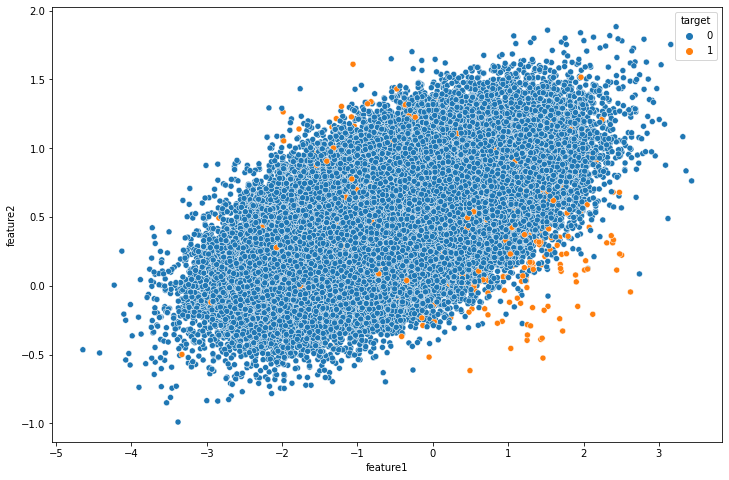

In [ ]:
# Visualize the data
plt.figure(figsize=(12, 8))
sns.scatterplot(x = 'feature1', y = 'feature2', hue = 'target', data = df)

# Step 3: Train Test Split

In this step, we split the dataset into 80% training data and 20% validation data. random_state ensures that we have the same train test split every time. The seed number for random_state does not have to be 42, and it can be any number.

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the majority class and {sorted(Counter(y_train).items())[1][1]} records for the minority class.")

The number of records in the training dataset is 80000
The number of records in the test dataset is 20000
The training dataset has 79183 records for the majority class and 817 records for the minority class.


The train test split gives us 80,000 records for the training dataset and 20,000 for the validation dataset. Thus, we have 79,183 data points from the majority class and 817 from the minority class in the training dataset.


# Step 4: Baseline Model

We will use cross-validation to evaluate the model performance and use minority class recall as the north star metric.

In [ ]:
# Train the random forest model using the imbalanced dataset
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
baseline_model_cv = cross_validate(rf, X_train, y_train, cv=StratifiedKFold(n_splits=5), n_jobs=-1, scoring="recall")

# Check the model performance
print(f"{baseline_model_cv['test_score'].mean():.3f} +/- {baseline_model_cv['test_score'].std():.3f}")

0.043 +/- 0.016


The stratified 5-fold cross-validation gives the recall value of 0.043 and the standard deviation of 0.016.

# Step 5: Algorithm Behind The Weights

The weights are calculated using the inverse proportion of class frequencies.
There are 79,183 data points from the majority class and 817 from the minority class in our training dataset. So the weight for the majority class would be 1.010, and the weight for the minority class is 97.919



In [ ]:
# Calculate weights manually
print(f'The weights for the majority class is {1/(79183/(79183 + 817)):.3f}')
print(f'The weights for the minority class is {1/(817/(79183 + 817)):.3f}')

The weights for the majority class is 1.010
The weights for the majority class is 97.919


sklearn has a built-in utility function compute_class_weight to calculate the class weights.

In [ ]:
# Calculate weights using sklearn
sklearn_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
sklearn_weights

array([ 0.50515894, 48.95960832])

If we multiply the compute_class_weight by 2, the results are the same as our manual calculation.

In [ ]:
# Compare the values
print(f'The weights for the majority class is {sklearn_weights[0]*2:.3f}')
print(f'The weights for the minority class is {sklearn_weights[1]*2:.3f}')

The weights for the majority class is 1.010
The weights for the minority class is 97.919


# Step 6: Random Forest Classifier: Balanced Class Weight

The `RandomForestClassifier` in sklearn has the option of `class_weight`. The default value for `class_weight` is None, meaning that all classes have the same weight of 1.


`class_weight` can take two values, balanced and `balanced_subsample`. We will use balanced for this step and `balanced_subsample` for the next step.


In [ ]:
# Train the random forest model using class_weight = 'balanced'
rf_balanced = RandomForestClassifier(class_weight='balanced', random_state=0, n_jobs=-1)
rf_balanced_cv = cross_validate(rf_balanced, X_train, y_train, cv=StratifiedKFold(n_splits=5), n_jobs=-1, scoring="recall")

# Check the model performance
print(f"{rf_balanced_cv['test_score'].mean():.3f} +/- {rf_balanced_cv['test_score'].std():.3f}")

0.031 +/- 0.015


The `class_weight='balanced'` option did not increase the model performance. On the contrary, it performed worse than the baseline model. Thus, we can see that it's crucial to have a baseline model to compare with, and do not blindly choose an imbalance adjustment algorithm and assume it has been taken good care of.

# Step 7: Random Forest Classifier: Balanced Subsample Class Weight

In this step, let's try `class_weight='balanced_subsample'` and see how it performs.

The difference between `'balanced_subsample'` and `'balanced'` is that `'balanced_subsample'` calculates the weights based on the samples for each tree, while `'balanced'` has the same weights for every tree based on the calculation of all the modeling data points.



In [ ]:
# Train the random forest model using class_weight = 'balanced_subsample'
rf_balanced_subsample = RandomForestClassifier(class_weight='balanced_subsample', random_state=0, n_jobs=-1)
rf_balanced_subsample_cv = cross_validate(rf_balanced_subsample, X_train, y_train, cv=StratifiedKFold(n_splits=5), n_jobs=-1, scoring="recall")

# Check the model performance
print(f"{rf_balanced_subsample_cv['test_score'].mean():.3f} +/- {rf_balanced_subsample_cv['test_score'].std():.3f}")

0.031 +/- 0.015


We got the same results as the `class_weight='balanced'` option.

# Step 8: Balanced Weights For Logistic Regression

Balanced weights did not improve the performance of a random forest. Is it because of the modeling algorithm we chose? Let's try the balanced weights on the good old logistic regression and see if it improves the model performance.

In [ ]:
# Train the logistic regression model using the imbalanced dataset
lr = LogisticRegression(random_state=0, n_jobs=-1)
lr_baseline_model_cv = cross_validate(lr, X_train, y_train, cv=StratifiedKFold(n_splits=5), n_jobs=-1, scoring="recall")

# Check the model performance
print(f"{lr_baseline_model_cv['test_score'].mean():.3f} +/- {lr_baseline_model_cv['test_score'].std():.3f}")

0.000 +/- 0.000


We can see that running the logistic regression on the imbalanced dataset gave us a recall of 0, meaning that none of the minority class data points was predicted correctly. Thus, the logistic regression baseline model has worse performance than the random forest baseline model.

Now let's try adding the balanced weights.

In [ ]:
# Train the logistic regression model using the balanced weights
lr_balanced = LogisticRegression(class_weight='balanced', random_state=0, n_jobs=-1)
lr_balanced_model_cv = cross_validate(lr, X_train, y_train, cv=StratifiedKFold(n_splits=5), n_jobs=-1, scoring="recall")

# Check the model performance
print(f"{lr_baseline_model_cv['test_score'].mean():.3f} +/- {lr_baseline_model_cv['test_score'].std():.3f}")

0.575 +/- 0.032


What a big difference the balanced weights made! The 5-fold stratified cross-validation improved the recall from 0 to 57.5%!

# Step 9: Use The Best Model On Training Dataset

The comparison above shows that the logistic regression with balanced weights has the best model performance. Now let's train the model using all the training dataset.

In [ ]:
# Train the logistic regression model using the balanced weights
lr_balanced = LogisticRegression(class_weight='balanced', random_state=0, n_jobs=-1)
lr_balanced_model = lr_balanced.fit(X_train, y_train)
lr_balanced_prediction = lr_balanced_model.predict(X_test)

# Check the model performance
print(classification_report(y_test, lr_balanced_prediction))

              precision    recall  f1-score   support

           0       0.99      0.63      0.77     19787
           1       0.02      0.55      0.03       213

    accuracy                           0.63     20000
   macro avg       0.50      0.59      0.40     20000
weighted avg       0.98      0.63      0.76     20000



Logistic regression gets a 55% recall value on the minority class, which significantly improves the baseline and balanced weights random forest models.

The performance is comparable with the best performance using under-sampling techniques (details in [this post about oversampling and under-sampling](https://grabngoinfo.com/oversampling-undersampling-smote-imbalanced-data-rare-event-modeling-classification-fraud-detection-python/)) and ensembling under-sampling (details [in this post about ensemble oversampling and under-sampling](https://grabngoinfo.com/ensemble-oversampling-and-under-sampling-for-imbalanced-classification-using-python/))


# Step 10: Put Everything Together

In [ ]:
###### Step 1: Import Libraries

# Synthetic dataset
from sklearn.datasets import make_classification

# Data processing
import pandas as pd
import numpy as np
from collections import Counter

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model and performance
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
from sklearn.metrics import classification_report


###### Step 2: Create Imbalanced Dataset

# Create an imbalanced dataset
X, y = make_classification(n_samples=100000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,
                           weights=[0.995, 0.005],
                           class_sep=0.5, random_state=0)

# Convert the data from numpy array to a pandas dataframe
df = pd.DataFrame({'feature1': X[:, 0], 'feature2': X[:, 1], 'target': y})

# Check the target distribution
df['target'].value_counts(normalize = True)

# Visualize the data
plt.figure(figsize=(12, 8))
sns.scatterplot(x = 'feature1', y = 'feature2', hue = 'target', data = df)


###### Step 3: Train Test Split

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the majority class and {sorted(Counter(y_train).items())[1][1]} records for the minority class.")


###### Step 4: Baseline Model

# Train the random forest model using the imbalanced dataset
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
baseline_model_cv = cross_validate(rf, X_train, y_train, cv=StratifiedKFold(n_splits=5), n_jobs=-1, scoring="recall")

# Check the model performance
print(f"{baseline_model_cv['test_score'].mean():.3f} +/- {baseline_model_cv['test_score'].std():.3f}")


###### Step 5: Algorithm Behind The Weights

# Calculate weights manually
print(f'The weights for the majority class is {1/(79183/(79183 + 817)):.3f}')
print(f'The weights for the minority class is {1/(817/(79183 + 817)):.3f}')

# Calculate weights using sklearn
sklearn_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
sklearn_weights

# Compare the values
print(f'The weights for the majority class is {sklearn_weights[0]*2:.3f}')
print(f'The weights for the minority class is {sklearn_weights[1]*2:.3f}')


###### Step 6: Random Forest Classifier: Balanced Class Weight

# Train the random forest model using class_weight = 'balanced'
rf_balanced = RandomForestClassifier(class_weight='balanced', random_state=0, n_jobs=-1)
rf_balanced_cv = cross_validate(rf_balanced, X_train, y_train, cv=StratifiedKFold(n_splits=5), n_jobs=-1, scoring="recall")

# Check the model performance
print(f"{rf_balanced_cv['test_score'].mean():.3f} +/- {rf_balanced_cv['test_score'].std():.3f}")


###### Step 7: Random Forest Classifier: Balanced Subsample Class Weight

# Train the random forest model using class_weight = 'balanced_subsample'
rf_balanced_subsample = RandomForestClassifier(class_weight='balanced_subsample', random_state=0, n_jobs=-1)
rf_balanced_subsample_cv = cross_validate(rf_balanced_subsample, X_train, y_train, cv=StratifiedKFold(n_splits=5), n_jobs=-1, scoring="recall")

# Check the model performance
print(f"{rf_balanced_subsample_cv['test_score'].mean():.3f} +/- {rf_balanced_subsample_cv['test_score'].std():.3f}")


###### Step 8: Balanced Weights For Logistic Regression

# Train the logistic regression model using the imbalanced dataset
lr = LogisticRegression(random_state=0, n_jobs=-1)
lr_baseline_model_cv = cross_validate(lr, X_train, y_train, cv=StratifiedKFold(n_splits=5), n_jobs=-1, scoring="recall")

# Check the model performance
print(f"{lr_baseline_model_cv['test_score'].mean():.3f} +/- {lr_baseline_model_cv['test_score'].std():.3f}")

# Train the logistic regression model using the balanced weights
lr_balanced = LogisticRegression(class_weight='balanced', random_state=0, n_jobs=-1)
lr_balanced_model_cv = cross_validate(lr, X_train, y_train, cv=StratifiedKFold(n_splits=5), n_jobs=-1, scoring="recall")

# Check the model performance
print(f"{lr_baseline_model_cv['test_score'].mean():.3f} +/- {lr_baseline_model_cv['test_score'].std():.3f}")


###### Step 9: Use The Best Model On Training Dataset

# Train the logistic regression model using the balanced weights
lr_balanced = LogisticRegression(class_weight='balanced', random_state=0, n_jobs=-1)
lr_balanced_model = lr_balanced.fit(X_train, y_train)
lr_balanced_prediction = lr_balanced_model.predict(X_test)

# Check the model performance
print(classification_report(y_test, lr_balanced_prediction))


# Recommended Tutorials

- [GrabNGoInfo Machine Learning Tutorials Inventory](https://medium.com/grabngoinfo/grabngoinfo-machine-learning-tutorials-inventory-9b9d78ebdd67)
- [Hierarchical Topic Model for Airbnb Reviews](https://medium.com/p/hierarchical-topic-model-for-airbnb-reviews-f772eaa30434)
- [3 Ways for Multiple Time Series Forecasting Using Prophet in Python](https://medium.com/p/3-ways-for-multiple-time-series-forecasting-using-prophet-in-python-7a0709a117f9)
- [Time Series Anomaly Detection Using Prophet in Python](https://medium.com/grabngoinfo/time-series-anomaly-detection-using-prophet-in-python-877d2b7b14b4)
- [Time Series Causal Impact Analysis in Python](https://medium.com/grabngoinfo/time-series-causal-impact-analysis-in-python-63eacb1df5cc)
- [Hyperparameter Tuning For XGBoost](https://medium.com/p/hyperparameter-tuning-for-xgboost-91449869c57e)
- [Four Oversampling And Under-Sampling Methods For Imbalanced Classification Using Python](https://medium.com/p/four-oversampling-and-under-sampling-methods-for-imbalanced-classification-using-python-7304aedf9037)
- [Five Ways To Create Tables In Databricks](https://medium.com/grabngoinfo/five-ways-to-create-tables-in-databricks-cd3847cfc3aa)
- [Explainable S-Learner Uplift Model Using Python Package CausalML](https://medium.com/grabngoinfo/explainable-s-learner-uplift-model-using-python-package-causalml-a3c2bed3497c)
- [One-Class SVM For Anomaly Detection](https://medium.com/p/one-class-svm-for-anomaly-detection-6c97fdd6d8af)
- [Recommendation System: Item-Based Collaborative Filtering](https://medium.com/grabngoinfo/recommendation-system-item-based-collaborative-filtering-f5078504996a)
- [Hyperparameter Tuning for Time Series Causal Impact Analysis in Python](https://medium.com/grabngoinfo/hyperparameter-tuning-for-time-series-causal-impact-analysis-in-python-c8f7246c4d22)
- [Hyperparameter Tuning and Regularization for Time Series Model Using Prophet in Python](https://medium.com/grabngoinfo/hyperparameter-tuning-and-regularization-for-time-series-model-using-prophet-in-python-9791370a07dc)
- [Multivariate Time Series Forecasting with Seasonality and Holiday Effect Using Prophet in Python](https://medium.com/p/multivariate-time-series-forecasting-with-seasonality-and-holiday-effect-using-prophet-in-python-d5d4150eeb57)
- [LASSO (L1) Vs Ridge (L2) Vs Elastic Net Regularization For Classification Model](https://medium.com/towards-artificial-intelligence/lasso-l1-vs-ridge-l2-vs-elastic-net-regularization-for-classification-model-409c3d86f6e9)
- [S Learner Uplift Model for Individual Treatment Effect and Customer Segmentation in Python](https://medium.com/grabngoinfo/s-learner-uplift-model-for-individual-treatment-effect-and-customer-segmentation-in-python-9d410746e122)
- [How to Use R with Google Colab Notebook](https://medium.com/p/how-to-use-r-with-google-colab-notebook-610c3a2f0eab)

# References

* [Random Forest Classifier in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [Logistic Regression in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)